# Ethereum RNN Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
ethereum_csv = os.path.join(current_folder, "data","ethereum_hourly.csv")
ethereum_df = pd.read_csv(ethereum_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
ethereum_df['highLowDif'] = ethereum_df['highPriceUsd'] - ethereum_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
ethereum_df['datetime'] = pd.to_datetime(ethereum_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = ethereum_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = ethereum_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = ethereum_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
ethereum_df.iloc[0]

datetime                       2021-02-03 00:00:00+00:00
ethereum_count                                       508
ethereum_polarity                               0.172375
ethereum_subjectivity                           0.489083
ethereum_polarity_zeros                        0.0981143
ethereum_subjectivity_zeros                     0.321798
openPriceUsd                                     1514.77
closePriceUsd                                    1520.24
highPriceUsd                                     1530.61
lowPriceUsd                                      1514.77
volume                                       44437743410
marketcap                                   174085432619
highLowDif                                       15.8376
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'ethereum_polarity', 'ethereum_subjectivity','ethereum_polarity_zeros', 'ethereum_subjectivity_zeros', 'ethereum_count', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

closePriceUsd    1.520244e+03
highPriceUsd     1.530607e+03
lowPriceUsd      1.514770e+03
volume           4.443774e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 48      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 48, 4)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 4s 196ms/step - loss: 1.2717 - val_loss: 6.4866
Epoch 2/20
13/13 [==============================] - 2s 143ms/step - loss: 0.5180 - val_loss: 6.3852
Epoch 3/20
13/13 [==============================] - 2s 154ms/step - loss: 0.4592 - val_loss: 5.2388
Epoch 4/20
13/13 [==============================] - 2s 172ms/step - loss: 0.2491 - val_loss: 5.1674
Epoch 5/20
13/13 [==============================] - 2s 171ms/step - loss: 0.2921 - val_loss: 5.7628
Epoch 6/20
13/13 [==============================] - 2s 159ms/step - loss: 0.3783 - val_loss: 5.4653
Epoch 7/20
13/13 [==============================] - 2s 162ms/step - loss: 0.3040 - val_loss: 4.1818
Epoch 8/20
13/13 [==============================] - 2s 153ms/step - loss: 0.2302 - val_loss: 4.8008
Epoch 9/20
13/13 [==============================] - 2s 164ms/step - loss: 0.3223 - val_loss: 4.3860
Epoch 10/20
13/13 [==============================] - 2s 172ms/step - loss: 0.2309 - val_loss: 3.9452

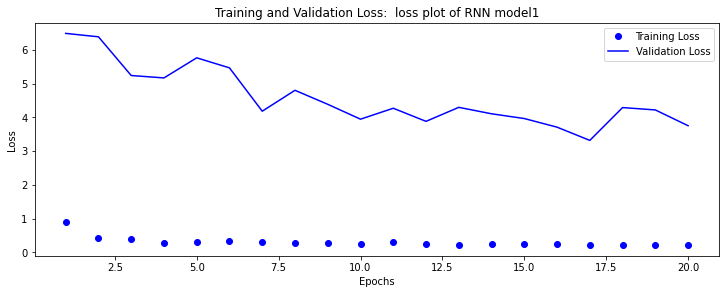

In [7]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 4s 203ms/step - loss: 0.8728 - val_loss: 3.5982
Epoch 2/20
13/13 [==============================] - 2s 172ms/step - loss: 0.5103 - val_loss: 3.5293
Epoch 3/20
13/13 [==============================] - 2s 165ms/step - loss: 0.4512 - val_loss: 3.6443
Epoch 4/20
13/13 [==============================] - 2s 184ms/step - loss: 0.4255 - val_loss: 3.9873
Epoch 5/20
13/13 [==============================] - 2s 173ms/step - loss: 0.3789 - val_loss: 3.8822
Epoch 6/20
13/13 [==============================] - 3s 216ms/step - loss: 0.3198 - val_loss: 4.7358
Epoch 7/20
13/13 [==============================] - 2s 166ms/step - loss: 0.4653 - val_loss: 4.1980
Epoch 8/20
13/13 [==============================] - 2s 181ms/step - loss: 0.3338 - val_loss: 4.3562
Epoch 9/20
13/13 [==============================] - 2s 173ms/step - loss: 0.3357 - val_loss: 3.6810
Epoch 10/20
13/13 [==============================] - 3s 200ms/step - loss: 0.2987 - val_loss: 4.2452

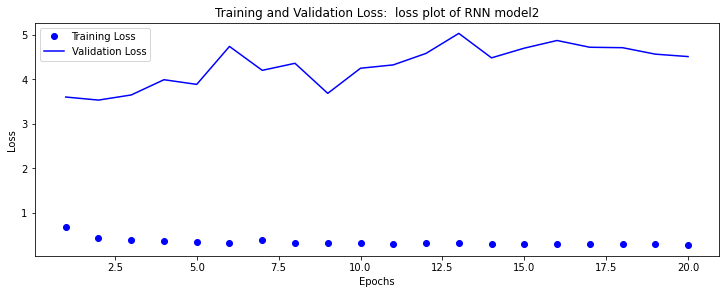

In [8]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 5s 243ms/step - loss: 0.8771 - val_loss: 7.2757
Epoch 2/30
13/13 [==============================] - 2s 141ms/step - loss: 0.4194 - val_loss: 6.2506
Epoch 3/30
13/13 [==============================] - 2s 166ms/step - loss: 0.3302 - val_loss: 6.0007
Epoch 4/30
13/13 [==============================] - 2s 134ms/step - loss: 0.3113 - val_loss: 6.0930
Epoch 5/30
13/13 [==============================] - 2s 131ms/step - loss: 0.2955 - val_loss: 5.2448
Epoch 6/30
13/13 [==============================] - 1s 118ms/step - loss: 0.2527 - val_loss: 5.2205
Epoch 7/30
13/13 [==============================] - 2s 133ms/step - loss: 0.3132 - val_loss: 5.3383
Epoch 8/30
13/13 [==============================] - 2s 138ms/step - loss: 0.2679 - val_loss: 4.5840
Epoch 9/30
13/13 [==============================] - 2s 154ms/step - loss: 0.2576 - val_loss: 4.5425
Epoch 10/30
13/13 [==============================] - 2s 137ms/step - loss: 0.2244 - val_loss: 4.7697

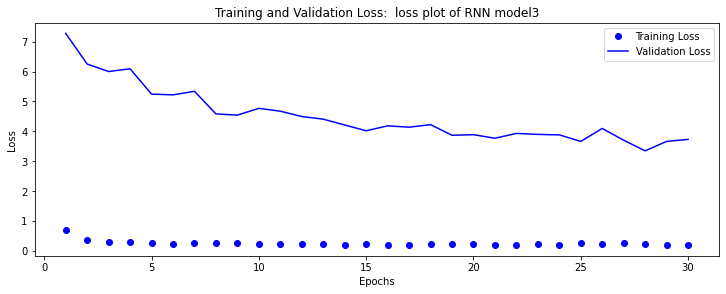

In [9]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 5s 216ms/step - loss: 1.0205 - val_loss: 5.7078
Epoch 2/30
13/13 [==============================] - 2s 162ms/step - loss: 0.5526 - val_loss: 4.8615
Epoch 3/30
13/13 [==============================] - 2s 151ms/step - loss: 0.3992 - val_loss: 4.6065
Epoch 4/30
13/13 [==============================] - 2s 180ms/step - loss: 0.4060 - val_loss: 4.9418
Epoch 5/30
13/13 [==============================] - 3s 248ms/step - loss: 0.3703 - val_loss: 4.9060
Epoch 6/30
13/13 [==============================] - 2s 153ms/step - loss: 0.3487 - val_loss: 4.6033
Epoch 7/30
13/13 [==============================] - 2s 124ms/step - loss: 0.3272 - val_loss: 5.1874
Epoch 8/30
13/13 [==============================] - 2s 193ms/step - loss: 0.3288 - val_loss: 5.0704
Epoch 9/30
13/13 [==============================] - 2s 142ms/step - loss: 0.3114 - val_loss: 5.2979
Epoch 10/30
13/13 [==============================] - 2s 194ms/step - loss: 0.3011 - val_loss: 5.1284

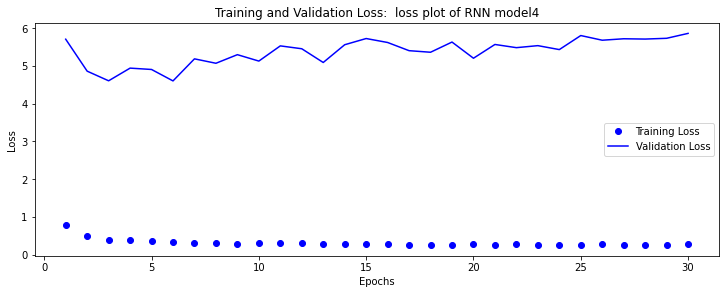

In [10]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 3s 135ms/step - loss: 0.4944 - val_loss: 6.8883
Epoch 2/30
13/13 [==============================] - 2s 173ms/step - loss: 0.3558 - val_loss: 6.6220
Epoch 3/30
13/13 [==============================] - 1s 101ms/step - loss: 0.2943 - val_loss: 6.4331
Epoch 4/30
13/13 [==============================] - 2s 119ms/step - loss: 0.2780 - val_loss: 6.2825
Epoch 5/30
13/13 [==============================] - 2s 120ms/step - loss: 0.2527 - val_loss: 6.2553
Epoch 6/30
13/13 [==============================] - 2s 122ms/step - loss: 0.2306 - val_loss: 6.1317
Epoch 7/30
13/13 [==============================] - 2s 123ms/step - loss: 0.2198 - val_loss: 6.1764
Epoch 8/30
13/13 [==============================] - 1s 117ms/step - loss: 0.2133 - val_loss: 6.0294
Epoch 9/30
13/13 [==============================] - 1s 98ms/step - loss: 0.1900 - val_loss: 6.4231
Epoch 10/30
13/13 [==============================] - 1s 118ms/step - loss: 0.2124 - val_loss: 6.1647


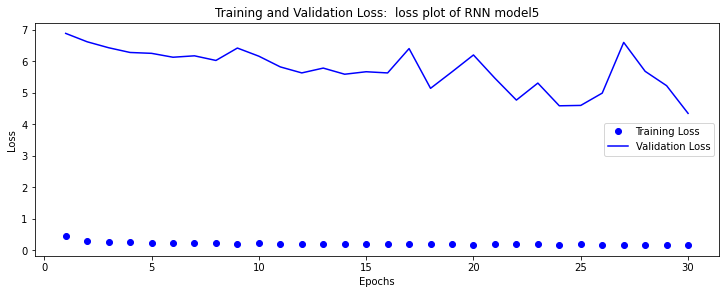

In [11]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 4s 173ms/step - loss: 0.6671 - val_loss: 7.2065
Epoch 2/30
13/13 [==============================] - 2s 131ms/step - loss: 0.5558 - val_loss: 6.8688
Epoch 3/30
13/13 [==============================] - 2s 144ms/step - loss: 0.4147 - val_loss: 6.4400
Epoch 4/30
13/13 [==============================] - 2s 151ms/step - loss: 0.3626 - val_loss: 6.3005
Epoch 5/30
13/13 [==============================] - 2s 139ms/step - loss: 0.3459 - val_loss: 6.5145
Epoch 6/30
13/13 [==============================] - 2s 129ms/step - loss: 0.3243 - val_loss: 6.3702
Epoch 7/30
13/13 [==============================] - 2s 141ms/step - loss: 0.3285 - val_loss: 6.4032
Epoch 8/30
13/13 [==============================] - 2s 151ms/step - loss: 0.3252 - val_loss: 6.5158
Epoch 9/30
13/13 [==============================] - 2s 148ms/step - loss: 0.2991 - val_loss: 6.3950
Epoch 10/30
13/13 [==============================] - 2s 140ms/step - loss: 0.2864 - val_loss: 6.2426

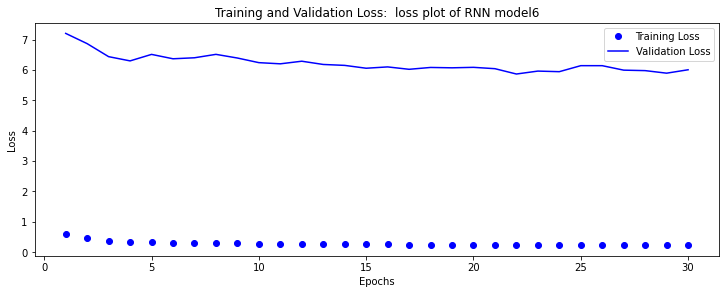

In [12]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 5s 205ms/step - loss: 0.8113 - val_loss: 6.7005
Epoch 2/40
13/13 [==============================] - 2s 137ms/step - loss: 0.3517 - val_loss: 6.1077
Epoch 3/40
13/13 [==============================] - 2s 154ms/step - loss: 0.2853 - val_loss: 5.6927
Epoch 4/40
13/13 [==============================] - 2s 123ms/step - loss: 0.2629 - val_loss: 5.4865
Epoch 5/40
13/13 [==============================] - 2s 121ms/step - loss: 0.2468 - val_loss: 5.3802
Epoch 6/40
13/13 [==============================] - 2s 137ms/step - loss: 0.2353 - val_loss: 5.3204
Epoch 7/40
13/13 [==============================] - 2s 133ms/step - loss: 0.2275 - val_loss: 5.2821
Epoch 8/40
13/13 [==============================] - 2s 137ms/step - loss: 0.2210 - val_loss: 5.2631
Epoch 9/40
13/13 [==============================] - 2s 121ms/step - loss: 0.2161 - val_loss: 5.2484
Epoch 10/40
13/13 [==============================] - 2s 124ms/step - loss: 0.2120 - val_loss: 5.2383

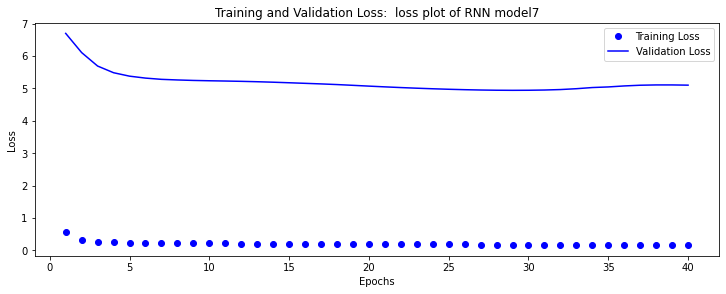

In [13]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 4s 160ms/step - loss: 0.5711 - val_loss: 7.6299
Epoch 2/30
13/13 [==============================] - 2s 135ms/step - loss: 0.4408 - val_loss: 7.4458
Epoch 3/30
13/13 [==============================] - 2s 132ms/step - loss: 0.3522 - val_loss: 7.0431
Epoch 4/30
13/13 [==============================] - 2s 156ms/step - loss: 0.3385 - val_loss: 7.0675
Epoch 5/30
13/13 [==============================] - 2s 131ms/step - loss: 0.3171 - val_loss: 7.1177
Epoch 6/30
13/13 [==============================] - 2s 131ms/step - loss: 0.3037 - val_loss: 7.1657
Epoch 7/30
13/13 [==============================] - 2s 118ms/step - loss: 0.2771 - val_loss: 7.1839
Epoch 8/30
13/13 [==============================] - 1s 113ms/step - loss: 0.3016 - val_loss: 7.3588
Epoch 9/30
13/13 [==============================] - 2s 139ms/step - loss: 0.2587 - val_loss: 7.1097
Epoch 10/30
13/13 [==============================] - 2s 134ms/step - loss: 0.2821 - val_loss: 7.0265

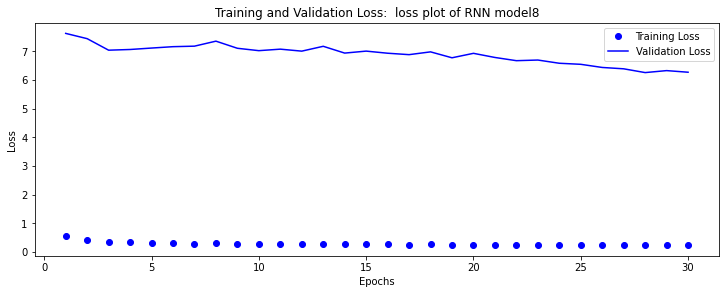

In [14]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 4s 169ms/step - loss: 0.7329 - val_loss: 14.8934
Epoch 2/20
13/13 [==============================] - 2s 120ms/step - loss: 0.2828 - val_loss: 13.4868
Epoch 3/20
13/13 [==============================] - 2s 118ms/step - loss: 0.2743 - val_loss: 12.1012
Epoch 4/20
13/13 [==============================] - 2s 171ms/step - loss: 0.2511 - val_loss: 11.0339
Epoch 5/20
13/13 [==============================] - 2s 120ms/step - loss: 0.2326 - val_loss: 10.2905
Epoch 6/20
13/13 [==============================] - 2s 126ms/step - loss: 0.2172 - val_loss: 9.7732
Epoch 7/20
13/13 [==============================] - 1s 95ms/step - loss: 0.2047 - val_loss: 9.3670
Epoch 8/20
13/13 [==============================] - 1s 113ms/step - loss: 0.1939 - val_loss: 9.0502
Epoch 9/20
13/13 [==============================] - 2s 171ms/step - loss: 0.1862 - val_loss: 8.8107
Epoch 10/20
13/13 [==============================] - 2s 191ms/step - loss: 0.1814 - val_loss: 8.

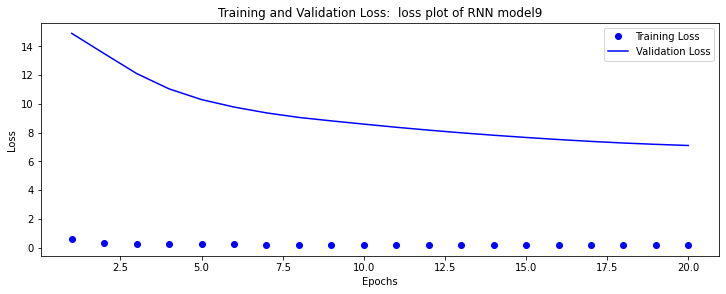

In [15]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 4s 173ms/step - loss: 0.4619 - val_loss: 11.2931
Epoch 2/20
13/13 [==============================] - 1s 115ms/step - loss: 0.3383 - val_loss: 10.4392
Epoch 3/20
13/13 [==============================] - 2s 135ms/step - loss: 0.3198 - val_loss: 9.8903
Epoch 4/20
13/13 [==============================] - 1s 110ms/step - loss: 0.2946 - val_loss: 9.4832
Epoch 5/20
13/13 [==============================] - 1s 114ms/step - loss: 0.2827 - val_loss: 9.1605
Epoch 6/20
13/13 [==============================] - 2s 121ms/step - loss: 0.2735 - val_loss: 8.9935
Epoch 7/20
13/13 [==============================] - 1s 107ms/step - loss: 0.2681 - val_loss: 8.8031
Epoch 8/20
13/13 [==============================] - 2s 129ms/step - loss: 0.2789 - val_loss: 8.6910
Epoch 9/20
13/13 [==============================] - 2s 138ms/step - loss: 0.2602 - val_loss: 8.6229
Epoch 10/20
13/13 [==============================] - 2s 167ms/step - loss: 0.2607 - val_loss: 8.52

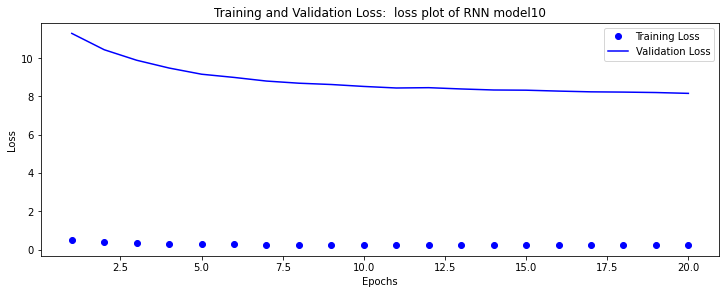

In [16]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 3s 139ms/step - loss: 2.6061 - val_loss: 34.3875
Epoch 2/40
13/13 [==============================] - 2s 120ms/step - loss: 1.9913 - val_loss: 32.0912
Epoch 3/40
13/13 [==============================] - 2s 165ms/step - loss: 1.6904 - val_loss: 29.9234
Epoch 4/40
13/13 [==============================] - 2s 158ms/step - loss: 1.4042 - val_loss: 27.8285
Epoch 5/40
13/13 [==============================] - 1s 106ms/step - loss: 1.2413 - val_loss: 25.7773
Epoch 6/40
13/13 [==============================] - 1s 114ms/step - loss: 1.0378 - val_loss: 23.7805
Epoch 7/40
13/13 [==============================] - 1s 113ms/step - loss: 0.9149 - val_loss: 21.9075
Epoch 8/40
13/13 [==============================] - 1s 107ms/step - loss: 0.7811 - val_loss: 19.9965
Epoch 9/40
13/13 [==============================] - 1s 98ms/step - loss: 0.7195 - val_loss: 18.1352
Epoch 10/40
13/13 [==============================] - 2s 126ms/step - loss: 0.6117 - val_loss

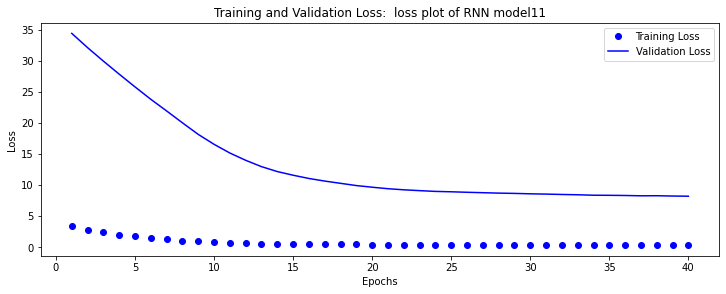

In [17]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 5s 174ms/step - loss: 0.7537 - val_loss: 5.5958
Epoch 2/30
13/13 [==============================] - 2s 148ms/step - loss: 0.5291 - val_loss: 5.3919
Epoch 3/30
13/13 [==============================] - 3s 205ms/step - loss: 0.4483 - val_loss: 5.4833
Epoch 4/30
13/13 [==============================] - 2s 183ms/step - loss: 0.4184 - val_loss: 5.2754
Epoch 5/30
13/13 [==============================] - 2s 179ms/step - loss: 0.3764 - val_loss: 4.9744
Epoch 6/30
13/13 [==============================] - 2s 170ms/step - loss: 0.3869 - val_loss: 5.0303
Epoch 7/30
13/13 [==============================] - 2s 174ms/step - loss: 0.3448 - val_loss: 5.4012
Epoch 8/30
13/13 [==============================] - 3s 218ms/step - loss: 0.3312 - val_loss: 5.3711
Epoch 9/30
13/13 [==============================] - 2s 158ms/step - loss: 0.3101 - val_loss: 5.1124
Epoch 10/30
13/13 [==============================] - 2s 162ms/step - loss: 0.3247 - val_loss: 5.6557

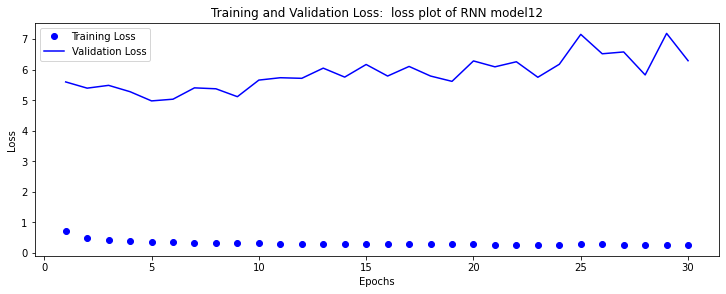

In [18]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 6s 203ms/step - loss: 0.7991 - val_loss: 4.9600
Epoch 2/30
13/13 [==============================] - 2s 171ms/step - loss: 0.7826 - val_loss: 5.2656
Epoch 3/30
13/13 [==============================] - 2s 195ms/step - loss: 0.5540 - val_loss: 5.1769
Epoch 4/30
13/13 [==============================] - 3s 240ms/step - loss: 0.4777 - val_loss: 5.4236
Epoch 5/30
13/13 [==============================] - 2s 187ms/step - loss: 0.4086 - val_loss: 5.7048
Epoch 6/30
13/13 [==============================] - 3s 202ms/step - loss: 0.3850 - val_loss: 5.8233
Epoch 7/30
13/13 [==============================] - 2s 179ms/step - loss: 0.3831 - val_loss: 6.1340
Epoch 8/30
13/13 [==============================] - 2s 183ms/step - loss: 0.3622 - val_loss: 6.0891
Epoch 9/30
13/13 [==============================] - 3s 224ms/step - loss: 0.3512 - val_loss: 6.0080
Epoch 10/30
13/13 [==============================] - 4s 284ms/step - loss: 0.3599 - val_loss: 6.1251

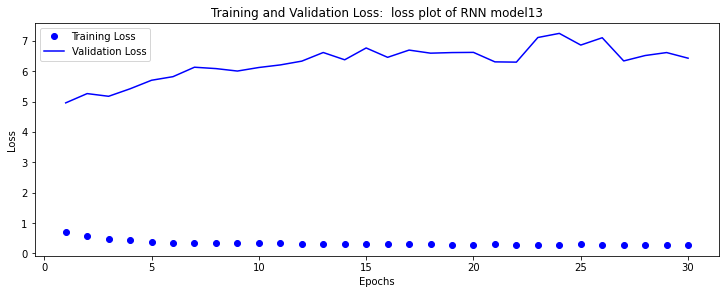

In [19]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 3s 158ms/step - loss: 0.9137 - val_loss: 8.6944
Epoch 2/20
13/13 [==============================] - 2s 159ms/step - loss: 0.3213 - val_loss: 8.1732
Epoch 3/20
13/13 [==============================] - 2s 119ms/step - loss: 0.2829 - val_loss: 7.4544
Epoch 4/20
13/13 [==============================] - 1s 97ms/step - loss: 0.2591 - val_loss: 7.0559
Epoch 5/20
13/13 [==============================] - 1s 108ms/step - loss: 0.2312 - val_loss: 6.8064
Epoch 6/20
13/13 [==============================] - 1s 116ms/step - loss: 0.2269 - val_loss: 6.5362
Epoch 7/20
13/13 [==============================] - 1s 111ms/step - loss: 0.2188 - val_loss: 6.6955
Epoch 8/20
13/13 [==============================] - 2s 118ms/step - loss: 0.2239 - val_loss: 6.4745
Epoch 9/20
13/13 [==============================] - 1s 115ms/step - loss: 0.2199 - val_loss: 6.2080
Epoch 10/20
13/13 [==============================] - 1s 109ms/step - loss: 0.1998 - val_loss: 6.9079


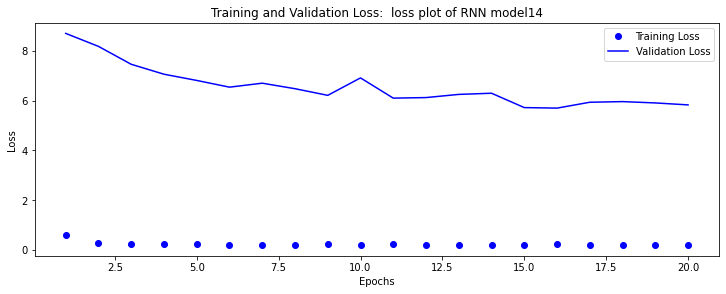

In [20]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 5s 345ms/step - loss: 2.5700 - val_loss: 18.0143
Epoch 2/20
13/13 [==============================] - 2s 124ms/step - loss: 0.8143 - val_loss: 15.5499
Epoch 3/20
13/13 [==============================] - 2s 125ms/step - loss: 0.5032 - val_loss: 13.2019
Epoch 4/20
13/13 [==============================] - 2s 122ms/step - loss: 0.3445 - val_loss: 11.1934
Epoch 5/20
13/13 [==============================] - 2s 186ms/step - loss: 0.2745 - val_loss: 9.8045
Epoch 6/20
13/13 [==============================] - 2s 126ms/step - loss: 0.2524 - val_loss: 9.1016
Epoch 7/20
13/13 [==============================] - 2s 157ms/step - loss: 0.2375 - val_loss: 8.7507
Epoch 8/20
13/13 [==============================] - 1s 108ms/step - loss: 0.2234 - val_loss: 8.5406
Epoch 9/20
13/13 [==============================] - 1s 107ms/step - loss: 0.2130 - val_loss: 8.4125
Epoch 10/20
13/13 [==============================] - 1s 109ms/step - loss: 0.2061 - val_loss: 8.

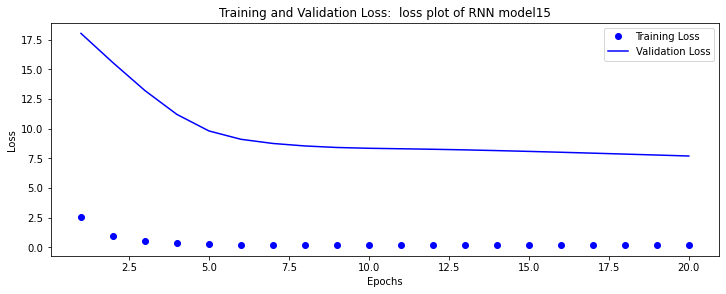

In [21]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 3s 116ms/step - loss: 1.1438 - val_loss: 9.6287
Epoch 2/20
13/13 [==============================] - 1s 116ms/step - loss: 0.4617 - val_loss: 8.9091
Epoch 3/20
13/13 [==============================] - 2s 122ms/step - loss: 0.3333 - val_loss: 8.3867
Epoch 4/20
13/13 [==============================] - 1s 118ms/step - loss: 0.3383 - val_loss: 7.3171
Epoch 5/20
13/13 [==============================] - 2s 122ms/step - loss: 0.2533 - val_loss: 7.5529
Epoch 6/20
13/13 [==============================] - 2s 148ms/step - loss: 0.3495 - val_loss: 6.5530
Epoch 7/20
13/13 [==============================] - 2s 197ms/step - loss: 0.2267 - val_loss: 6.6978
Epoch 8/20
13/13 [==============================] - 3s 215ms/step - loss: 0.2970 - val_loss: 6.1159
Epoch 9/20
13/13 [==============================] - 2s 137ms/step - loss: 0.2448 - val_loss: 6.5469
Epoch 10/20
13/13 [==============================] - 2s 122ms/step - loss: 0.2933 - val_loss: 6.0077

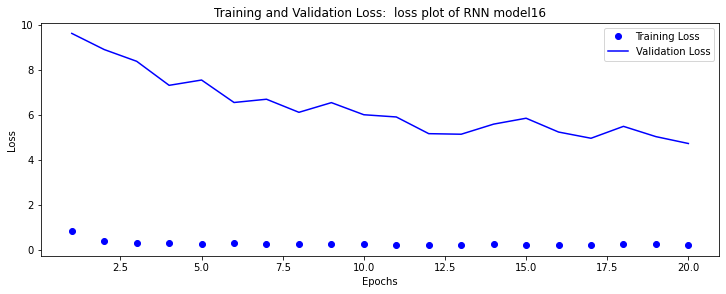

In [22]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 5s 198ms/step - loss: 1.5720 - val_loss: 8.8690
Epoch 2/20
13/13 [==============================] - 2s 133ms/step - loss: 0.5886 - val_loss: 7.2798
Epoch 3/20
13/13 [==============================] - 2s 190ms/step - loss: 0.3768 - val_loss: 6.9321
Epoch 4/20
13/13 [==============================] - 2s 134ms/step - loss: 0.3533 - val_loss: 6.7342
Epoch 5/20
13/13 [==============================] - 2s 160ms/step - loss: 0.3139 - val_loss: 7.5255
Epoch 6/20
13/13 [==============================] - 2s 189ms/step - loss: 0.2459 - val_loss: 6.8355
Epoch 7/20
13/13 [==============================] - 2s 131ms/step - loss: 0.3472 - val_loss: 7.0134
Epoch 8/20
13/13 [==============================] - 2s 137ms/step - loss: 0.2594 - val_loss: 7.6497
Epoch 9/20
13/13 [==============================] - 2s 148ms/step - loss: 0.2119 - val_loss: 6.9359
Epoch 10/20
13/13 [==============================] - 2s 158ms/step - loss: 0.3030 - val_loss: 7.3224

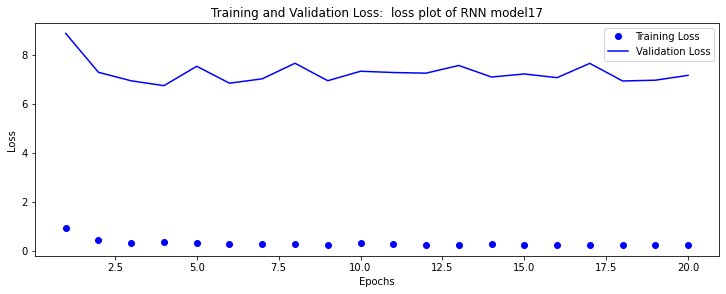

In [23]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 4s 157ms/step - loss: 0.6465 - val_loss: 8.3518
Epoch 2/20
13/13 [==============================] - 2s 137ms/step - loss: 0.3580 - val_loss: 8.7936
Epoch 3/20
13/13 [==============================] - 1s 105ms/step - loss: 0.2476 - val_loss: 9.2689
Epoch 4/20
13/13 [==============================] - 1s 105ms/step - loss: 0.2296 - val_loss: 9.1793
Epoch 5/20
13/13 [==============================] - 2s 156ms/step - loss: 0.1996 - val_loss: 9.2592
Epoch 6/20
13/13 [==============================] - 2s 129ms/step - loss: 0.2186 - val_loss: 9.4738
Epoch 7/20
13/13 [==============================] - 2s 132ms/step - loss: 0.2070 - val_loss: 9.2245
Epoch 8/20
13/13 [==============================] - 2s 199ms/step - loss: 0.1977 - val_loss: 9.2162
Epoch 9/20
13/13 [==============================] - 2s 123ms/step - loss: 0.1937 - val_loss: 9.2652
Epoch 10/20
13/13 [==============================] - 1s 102ms/step - loss: 0.1900 - val_loss: 9.0924

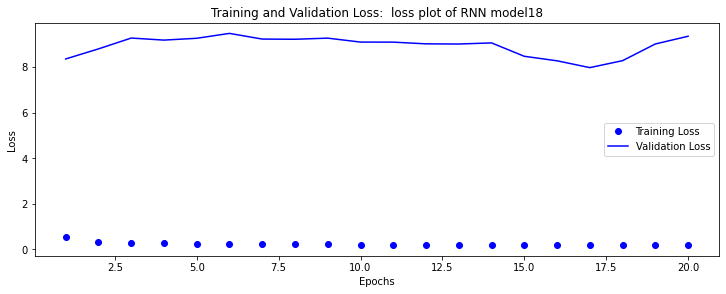

In [24]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")

In [25]:
histories = [RNN_model1_history, RNN_model2_history, RNN_model3_history, RNN_model4_history, RNN_model5_history, RNN_model6_history, RNN_model7_history, RNN_model8_history, RNN_model9_history, RNN_model10_history, RNN_model11_history, RNN_model12_history, RNN_model13_history, RNN_model14_history, RNN_model15_history, RNN_model16_history, RNN_model17_history, RNN_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 3.317063093185425, epoch: 17
Model 2: min val loss: 3.5292506217956543, epoch: 2
Model 3: min val loss: 3.3487114906311035, epoch: 28
Model 4: min val loss: 4.603291034698486, epoch: 6
Model 5: min val loss: 4.349776268005371, epoch: 30
Model 6: min val loss: 5.8679962158203125, epoch: 22
Model 7: min val loss: 4.943296432495117, epoch: 29
Model 8: min val loss: 6.260406017303467, epoch: 28
Model 9: min val loss: 7.100690841674805, epoch: 20
Model 10: min val loss: 8.16037368774414, epoch: 20
Model 11: min val loss: 8.189690589904785, epoch: 40
Model 12: min val loss: 4.9743547439575195, epoch: 5
Model 13: min val loss: 4.959972381591797, epoch: 1
Model 14: min val loss: 5.695082664489746, epoch: 16
Model 15: min val loss: 7.6950860023498535, epoch: 20
Model 16: min val loss: 4.727497100830078, epoch: 20
Model 17: min val loss: 6.734151840209961, epoch: 4
Model 18: min val loss: 7.9714508056640625, epoch: 17
